# Analysis of the heterogeneity of euro area countries and its implications for the implementation of the ECB's monetary policy

<b>Grant schema:</b>

Scientific project I-21-104-00 

<b>Research team:</b>

Juraj Dedinsky, Robert Hula, Marko Vateha, Mario Zeman

<b>Institution:</b>

University of Economics and Business in Bratislava

![UEBR](https://euba.sk/www_write/images/cache/3dc4b38399662dd1a15ad970fd72c08e_w1200.jpg)

### Libraries

In [1]:
# modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
from sklearn import preprocessing

# dendrogram
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

pd.set_option('max_columns', None)

#### Mappers

In [3]:
mapper = {'Austria':'AT', 'Belgium':'BE', 'Bulgaria':'BG', 'Croatia':'HR', 'Cyprus':'CY', 'Czech Republic':'CZ',
          'Denmark':'DK', 'Estonia':'EE', 'Finland':'FI', 'France':'FR', 'Germany':'DE', 'Greece':'EL',
          'Hungary':'HU', 'Ireland':'IE', 'Italy':'IT', 'Latvia':'LV', 'Lithuania':'LT', 'Luxembourg':'LU',
          'Malta':'MT', 'Netherlands':'NE', 'Poland':'PL', 'Portugal':'PT', 'Romania':'RO',
          'Slovak Republic':'SK', 'Slovenia':'SI', 'Spain':'ES', 'Sweden':'SE'}
mapper2 = {'Austria':1, 'Belgium':1, 'Bulgaria':2, 'Croatia':2, 'Cyprus':1, 'Czech Republic':2,
          'Denmark':2, 'Estonia':1, 'Finland':1, 'France':1, 'Germany':1, 'Greece':1,
          'Hungary':2, 'Ireland':1, 'Italy':1, 'Latvia':1, 'Lithuania':1, 'Luxembourg':1,
          'Malta':1, 'Netherlands':1, 'Poland':2, 'Portugal':1, 'Romania':2,
          'Slovak Republic':1, 'Slovenia':1, 'Spain':1, 'Sweden':2}

In [4]:
c_lib = {'Org. EA': ['Austria', 'Belgium', 'Finland', 'France', 'Germany', 'Greece', 'Ireland', 'Italy', 'Luxembourg', 'Netherlands', 'Portugal', 'Spain'],
         'Org. nonEA': ['Austria', 'Belgium', 'Finland', 'France', 'Germany', 'Greece', 'Ireland', 'Italy', 'Luxembourg', 'Netherlands', 'Portugal', 'Spain','Sweden', 'Denmark'],
         '2004': ['Cyprus', 'Estonia', 'Latvia', 'Lithuania', 'Malta', 'Slovak Republic', 'Slovenia', 'Czech Republic', 'Hungary', 'Poland'],
         '2004 EA': ['Cyprus', 'Estonia', 'Latvia', 'Lithuania', 'Malta', 'Slovak Republic', 'Slovenia'],
         '2004 nonEA': ['Cyprus', 'Estonia', 'Latvia', 'Lithuania', 'Malta', 'Slovak Republic', 'Slovenia', 'Czech Republic', 'Hungary', 'Poland'],
         'Org. plus 2004 EA': ['Austria', 'Belgium', 'Finland', 'France', 'Germany', 'Greece', 'Ireland', 'Italy', 'Luxembourg', 'Netherlands', 'Portugal', 'Spain', 'Cyprus', 'Estonia', 'Latvia', 'Lithuania', 'Malta', 'Slovak Republic', 'Slovenia'],
         'Org. plus 2004 nonEA': ['Austria', 'Belgium', 'Finland', 'France', 'Germany', 'Greece', 'Ireland', 'Italy', 'Luxembourg', 'Netherlands', 'Portugal', 'Spain', 'Cyprus', 'Estonia', 'Latvia', 'Lithuania', 'Malta', 'Slovak Republic', 'Slovenia', 'Czech Republic', 'Hungary', 'Poland', 'Sweden', 'Denmark'],
         'All': ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovak Republic', 'Slovenia', 'Spain', 'Sweden']}

# Data Transformation

#### Import

In [5]:
df_ = pd.read_excel(io='Research01_InputData.xlsx', sheet_name=None, header=[0,1], index_col=0)

# droping GDPPPP, GDPpc
df = df_['CA'].join([df_['Debt'], df_['GDPg'], df_['Inflation'], df_['Unemployment'], df_['Private debt']]).sort_index(axis=1, level=0).copy()

# droping projections
df = df.loc[1980:2019,:]

# Private debt Ireland
df.loc[1997:1998,('Ireland','Private')]=130

#percentage
df = df/100

#### Statistics

In [6]:
df.mean().to_frame().T.rename(index={0:'mean'})\
.append(df.std().to_frame().T.rename(index={0:'std'}))\
.T.stack().unstack(level=1)\
.to_excel('descriptive_stats.xlsx')

Key countries:
* 1980-1999 
* 1999-2004
* 2004-2009
* 2009-2019

New EA
* 1980-2004
* 2004-2009
* 2009-2019

#### Scaling of the data

As prerequisite for clustering, properly scaled inputs are needed.

name -> __scaled_df__

In [7]:
indicators = df.columns.get_level_values(level=1).unique()

new_df = pd.DataFrame()

for e,ind_ in enumerate(indicators):
    X_train = df.xs(ind_, axis=1, level=1).T
    
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_scaled = scaler.transform(X_train)
    
    scaled = pd.DataFrame(X_scaled, index=X_train.index, columns=X_train.columns)

    iterables = [scaled.index, [ind_]]
    scaled.index = pd.MultiIndex.from_product(iterables)

    if e==0:
        new_df = scaled.T
    else:
        new_df = new_df.join(scaled.T)
    
scaled_df = new_df.sort_index(axis=1, level=0)

#### Transformer

Preparing the pipeline which will transform data to dataset.

Parameters:

    std - if to involve STD
    normalize - if column STD is normalized by distribution mu=0, std=1

In [8]:
def transformer(y=range(1980,2020,1), c=c_lib['All'], std=False, normalize=True):
    mean_df = scaled_df.loc[y,c].mean().to_frame().rename(columns={0:'Mean'})\
    .unstack().droplevel(level=0, axis=1)
    final_df = mean_df.copy()
    
    if std:
        std_df = df.loc[y,c_lib['All']].std().to_frame().unstack(level=1).droplevel(axis=1, level=0).add_prefix('std_')
        
        if normalize:
            X_scaled = preprocessing.StandardScaler().fit_transform(std_df)
            scaled = pd.DataFrame(X_scaled, index=std_df.index, columns=std_df.columns)    
            std_df = scaled.loc[c,:].copy()
        
        final_df = mean_df.join(std_df)
        
    final_df.name = y[-1]
        
    return final_df

In [9]:
def unscaled_transformer(y=range(1980,2020,1), c=c_lib['All'], std=False):
    mean_df = df.loc[y,c].mean().to_frame().rename(columns={0:'Mean'})\
    .unstack().droplevel(level=0, axis=1)
    final_df = mean_df.copy()
    
    if std:
        std_df = df.loc[y,c_lib['All']].std().to_frame().unstack(level=1).droplevel(axis=1, level=0).add_prefix('std_')
        final_df = mean_df.join(std_df)
        
    final_df.name = y[-1]
        
    return final_df

In [10]:
transformer(range(1980,2005,1), c_lib['Org. EA'], std=True)

,CA,Debt,GDPg,Inflation,Private,Unemp,std_CA,std_Debt,std_GDPg,std_Inflation,std_Private,std_Unemp
Austria,0.168277,0.154025,-0.256979,-0.490500,0.304782,-0.989927,-0.942538,-0.691604,-1.117872,-0.382807,-0.664772,-1.152537
Belgium,0.928136,2.093759,-0.266705,-0.434725,0.201577,0.198281,-0.134595,1.050260,-0.912145,-0.375384,-0.592833,-0.791686
Finland,0.301999,-0.740955,0.140889,-0.346423,-0.054901,0.174664,0.699365,1.214011,0.012848,-0.364364,-0.722990,1.061088
France,0.407635,-0.322457,-0.238862,-0.298766,0.019037,0.232759,-1.114613,0.949470,-1.077478,-0.357845,-1.028206,-0.966879
Germany,0.658995,-0.069323,-0.415720,-0.551313,0.345518,-0.077062,-0.641936,-0.143720,-0.773479,-0.382260,-0.952932,-0.700040
Greece,-0.620727,0.724153,-0.285744,0.463393,-0.745495,0.117261,-0.865242,3.234315,-0.324749,-0.316113,0.063192,-0.205477
Ireland,-0.125800,-0.234674,0.690153,-0.110260,0.628684,0.807067,0.677647,1.400238,0.282298,-0.342240,-0.806049,2.334412
Italy,0.171174,1.793550,-0.342929,-0.045304,-0.351103,0.284367,-0.952332,0.011293,-1.054302,-0.339274,-0.625433,-0.907531
Luxembourg,2.237024,-1.552187,0.691698,-0.404553,0.671539,-1.346129,-0.754275,-1.235474,0.060186,-0.373473,2.754658,-1.214880
Netherlands,1.202239,0.253531,-0.122823,-0.478367,1.836578,-0.547942,-1.010747,0.331873,-0.735059,-0.382044,-0.016973,-0.785616


In [11]:
def dendogram_plot(df1, df2, df3, df4, y0=1980, title='EU members', ymax=15, save=False):
    plt.figure(4, figsize=(18,10), facecolor='#cecece')
    
    labelList = df1.index.map(mapper)

    plt.subplot(2, 2, 1)
    linked = linkage(df1, 'ward')
    dendrogram(linked, orientation='top', labels=labelList, distance_sort='descending', show_leaf_counts=True,
              color_threshold=0, above_threshold_color='k')
    plt.title(f'{title}\n(observations {y0}-{df1.name})')
    plt.ylabel('Euclidean distance')
    plt.ylim([0,ymax])

    plt.subplot(2, 2, 2)
    linked = linkage(df2, 'ward')
    dendrogram(linked, orientation='top', labels=labelList, distance_sort='descending', show_leaf_counts=True,
              color_threshold=0, above_threshold_color='k')
    plt.title(f'{title}\n(observations {df1.name}-{df2.name})')
    plt.ylabel('Euclidean distance')
    plt.ylim([0,ymax])

    plt.subplot(2, 2, 3)
    linked = linkage(df3, 'ward')
    dendrogram(linked, orientation='top', labels=labelList, distance_sort='descending', show_leaf_counts=True,
              color_threshold=0, above_threshold_color='k')
    plt.title(f'{title}\n(observations {df2.name}-{df3.name})')
    plt.ylabel('Euclidean distance')
    plt.ylim([0,ymax])

    plt.subplot(2, 2, 4)
    linked = linkage(df4, 'ward')
    dendrogram(linked, orientation='top', labels=labelList, distance_sort='descending', show_leaf_counts=True,
              color_threshold=0, above_threshold_color='k')
    plt.title(f'{title}\n(observations {df3.name}-{df4.name})')
    plt.ylabel('Euclidean distance')
    plt.ylim([0,ymax])

    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    # plt.suptitle('Original EU members over time 1980-2019 HAC analysis')
    
    if save:
        save_fig_name = title.replace(' ','_')
        plt.savefig(f'{save_fig_name}.png', facecolor='#cecece')
    
    plt.show()

### Different linkage methods

In [12]:
df_O_all_1980 = transformer(c=c_lib['Org. EA'], std=True)

### <font color='goldenrod'> Figure: 1 </font>

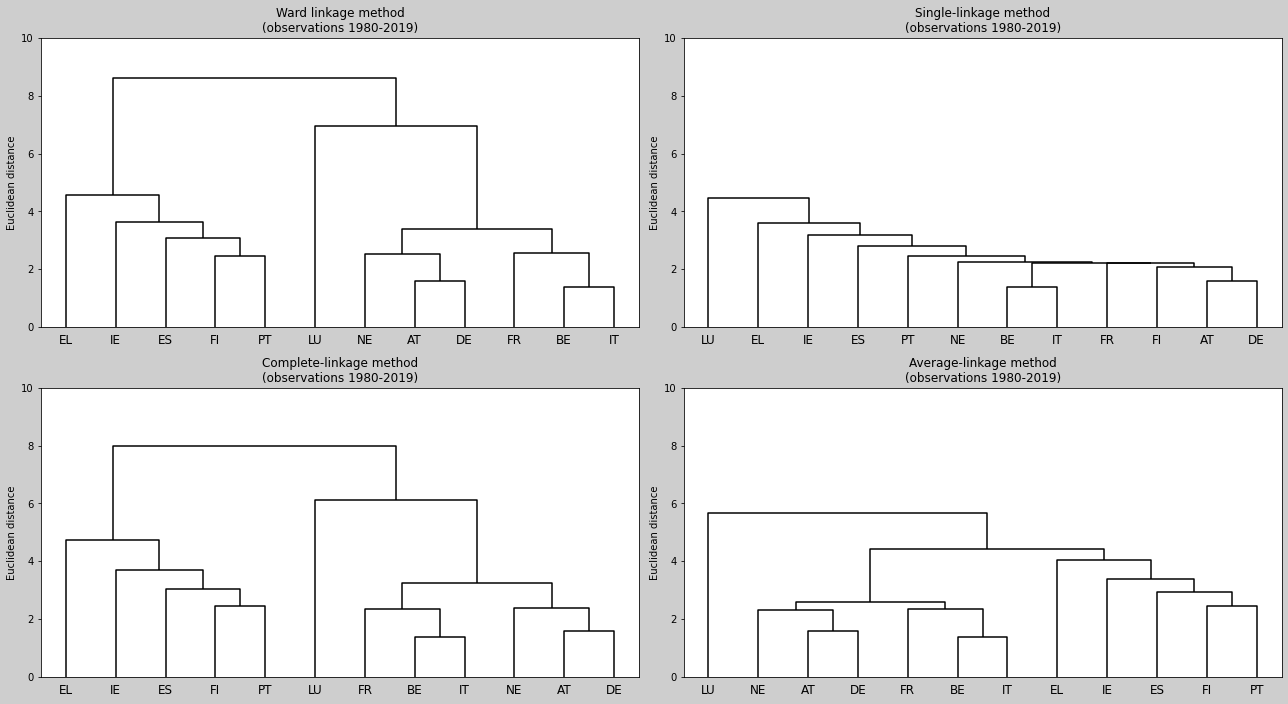

In [13]:
plt.figure(4, figsize=(18,10), facecolor='#cecece')

labelList = df_O_all_1980.index.map(mapper)

plt.subplot(2, 2, 1)
linked = linkage(df_O_all_1980, 'ward')
dendrogram(linked, orientation='top', labels=labelList, distance_sort='descending', show_leaf_counts=True,
           color_threshold=0, above_threshold_color='k')
plt.title('Ward linkage method\n(observations 1980-2019)')
plt.ylabel('Euclidean distance')
plt.ylim([0,10])

plt.subplot(2, 2, 2)
linked = linkage(df_O_all_1980, 'single')
dendrogram(linked, orientation='top', labels=labelList, distance_sort='descending', show_leaf_counts=True,
           color_threshold=0, above_threshold_color='k')
plt.title('Single-linkage method\n(observations 1980-2019)')
plt.ylabel('Euclidean distance')
plt.ylim([0,10])

plt.subplot(2, 2, 3)
linked = linkage(df_O_all_1980, 'complete')
dendrogram(linked, orientation='top', labels=labelList, distance_sort='descending', show_leaf_counts=True,
           color_threshold=0, above_threshold_color='k')
plt.title('Complete-linkage method\n(observations 1980-2019)')
plt.ylabel('Euclidean distance')
plt.ylim([0,10])

plt.subplot(2, 2, 4)
linked = linkage(df_O_all_1980, 'average')
dendrogram(linked, orientation='top', labels=labelList, distance_sort='descending', show_leaf_counts=True,
           color_threshold=0, above_threshold_color='k')
plt.title('Average-linkage method\n(observations 1980-2019)')
plt.ylabel('Euclidean distance')
plt.ylim([0,10])

'''
plt.subplot(3, 2, 5)
linked = linkage(df_O_all_1980, 'average')
dendrogram(linked, orientation='top', labels=labelList, distance_sort='descending', show_leaf_counts=True,
           color_threshold=0, above_threshold_color='k')
plt.title('Average method linkage')

plt.subplot(3, 2, 6)
linked = linkage(df_O_all_1980, 'centroid')
dendrogram(linked, orientation='top', labels=labelList, distance_sort='descending', show_leaf_counts=True,
           color_threshold=0, above_threshold_color='k')
plt.title('Centroid method linkage')
'''

plt.tight_layout()
plt.subplots_adjust(top=0.93)
# plt.suptitle('Original EU members over time 1980-1999 HAC analysis different methods', size='xx-large')
# plt.savefig('Linkage_methods.png', facecolor='#cecece')
plt.show()

# STD

### EU members prior 2004 intake

#### df

In [14]:
df_O_all_1998 = transformer(range(1980,1999,1), c_lib['Org. EA'], std=True)
df_O_all_2004 = transformer(range(1999,2005,1), c_lib['Org. EA'], std=True)
df_O_all_2009a = transformer(range(2005,2010,1), c_lib['Org. EA'], std=True)
df_O_all_2009b = transformer(range(1999,2010,1), c_lib['Org. EA'], std=True)
df_O_all_2014 = transformer(range(2005,2015,1), c_lib['Org. EA'], std=True)
df_O_all_2019a = transformer(range(2010,2020,1), c_lib['Org. EA'], std=True)
df_O_all_2019b = transformer(range(2015,2020,1), c_lib['Org. EA'], std=True)

#### Members priod 2004 - time windows (2004)

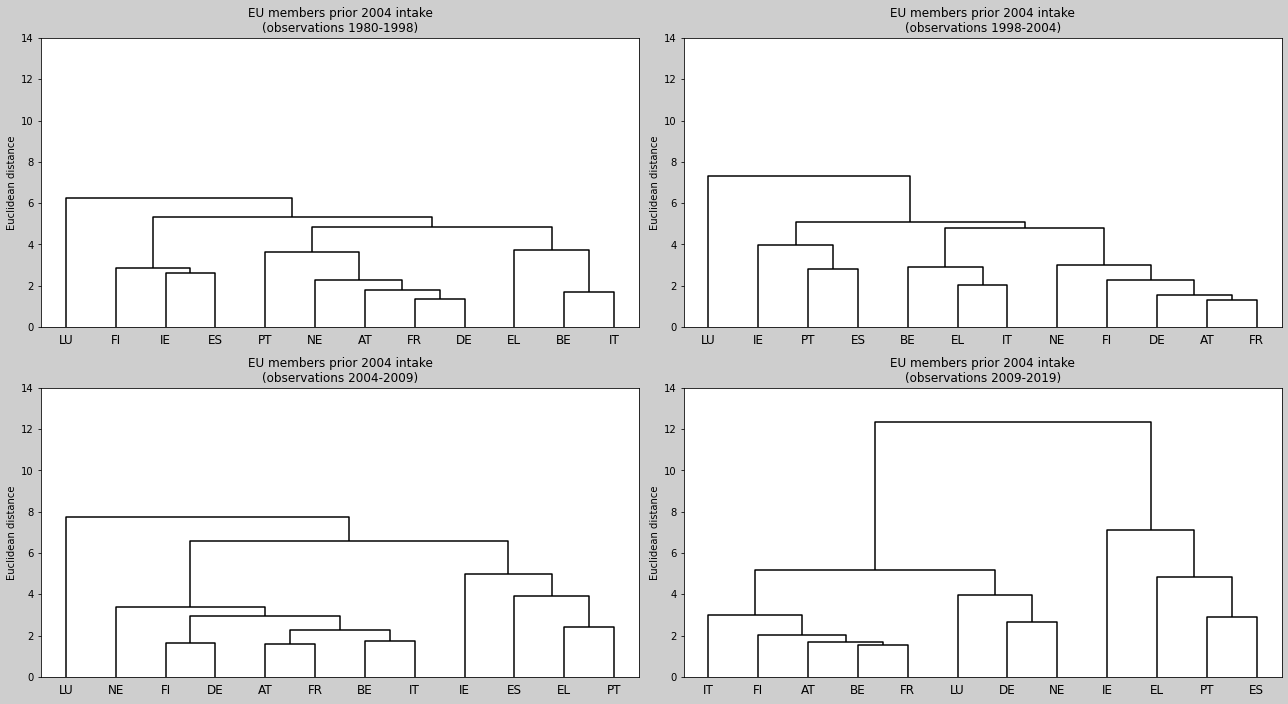

In [15]:
dendogram_plot(df_O_all_1998, df_O_all_2004, df_O_all_2009a, df_O_all_2019a, title='EU members prior 2004 intake', ymax=14)

### <font color='goldenrod'> Figure: 2 </font>

#### Members priod 2004 - time windows (2015)

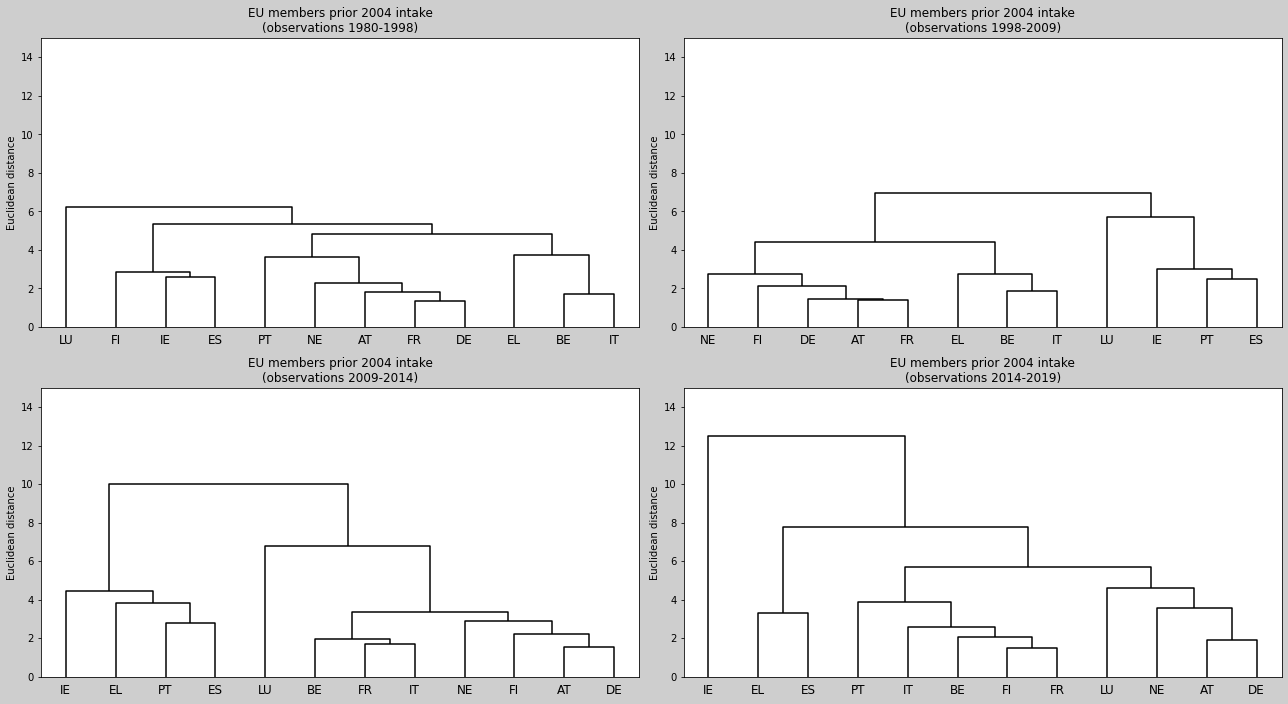

In [16]:
dendogram_plot(df_O_all_1998, df_O_all_2009b, df_O_all_2014, df_O_all_2019b, title='EU members prior 2004 intake')

In [17]:
df_O_all_1998 = unscaled_transformer(range(1980,1999,1), c_lib['Org. EA'], std=True)
df_O_all_2004 = unscaled_transformer(range(1999,2005,1), c_lib['Org. EA'], std=True)
df_O_all_2009a = unscaled_transformer(range(2005,2010,1), c_lib['Org. EA'], std=True)
df_O_all_2009b = unscaled_transformer(range(1999,2010,1), c_lib['Org. EA'], std=True)
df_O_all_2014 = unscaled_transformer(range(2005,2015,1), c_lib['Org. EA'], std=True)
df_O_all_2019a = unscaled_transformer(range(2010,2020,1), c_lib['Org. EA'], std=True)
df_O_all_2019b = unscaled_transformer(range(2015,2020,1), c_lib['Org. EA'], std=True)

In [18]:
df_O_all_1998

,CA,Debt,GDPg,Inflation,Private,Unemp,std_CA,std_Debt,std_GDPg,std_Inflation,std_Private,std_Unemp
Austria,-0.010526,0.612364,0.022000,0.030789,1.06200,0.034421,0.016863,0.052536,0.011785,0.017687,0.031123,0.008853
Belgium,0.019211,1.208947,0.020842,0.036053,0.99725,0.091526,0.031042,0.164815,0.015203,0.025544,0.055307,0.014238
Finland,-0.009526,0.285421,0.026579,0.049737,0.88950,0.085895,0.032203,0.183344,0.031488,0.034730,0.068695,0.046703
France,0.001947,0.387053,0.021211,0.048684,0.92650,0.090684,0.014355,0.133171,0.012205,0.042740,0.009574,0.013102
Germany,0.007789,0.505250,0.020421,0.027632,1.11775,0.073684,0.022602,0.082429,0.017199,0.018527,0.047310,0.015723
Greece,-0.029842,0.657526,0.013316,0.159263,0.37675,0.079368,0.015731,0.286278,0.021787,0.062004,0.023698,0.021321
Ireland,-0.018526,0.654250,0.043789,0.060053,1.30000,0.156143,0.047568,0.116983,0.033517,0.060631,0.000000,0.035440
Italy,-0.004737,1.123000,0.019211,0.080789,0.67150,0.092684,0.020177,0.111406,0.012295,0.058408,0.011210,0.013528
Luxembourg,0.104750,0.099500,0.046579,0.036053,1.12725,0.018842,0.015924,0.003109,0.029781,0.028238,0.162537,0.007841
Netherlands,0.031947,0.665316,0.026556,0.022500,1.93925,0.060632,0.015131,0.099607,0.016730,0.018700,0.026949,0.012872


In [19]:
df_O_all_2009b

,CA,Debt,GDPg,Inflation,Private,Unemp,std_CA,std_Debt,std_GDPg,std_Inflation,std_Private,std_Unemp
Austria,0.016727,0.670818,0.018818,0.017636,1.237455,0.047091,0.021057,0.046232,0.021381,0.008028,0.042373,0.006363
Belgium,0.029273,1.004364,0.019636,0.020182,1.284000,0.077455,0.022055,0.085918,0.017744,0.011223,0.218225,0.006832
Finland,0.047909,0.398727,0.023000,0.017818,1.095727,0.086000,0.020555,0.036699,0.037768,0.010685,0.170611,0.011739
France,0.007727,0.651455,0.016273,0.017545,1.093364,0.087273,0.014008,0.068556,0.018505,0.008214,0.104130,0.007431
Germany,0.030091,0.637818,0.008727,0.015545,1.181636,0.088636,0.031788,0.044420,0.025675,0.007421,0.051333,0.012044
Greece,-0.084273,1.072909,0.028091,0.031091,0.794273,0.099909,0.036335,0.074141,0.030333,0.008179,0.241704,0.012700
Ireland,-0.022727,0.348364,0.042545,0.029000,1.799333,0.057000,0.029679,0.115048,0.047771,0.018374,0.440374,0.024343
Italy,-0.008727,1.080182,0.006364,0.022727,0.939182,0.082000,0.010001,0.038049,0.023200,0.006769,0.165239,0.014533
Luxembourg,0.078455,0.093091,0.035818,0.026000,1.994545,0.035545,0.020176,0.032058,0.040632,0.012361,0.766530,0.010004
Netherlands,0.050909,0.496455,0.019727,0.022636,2.244727,0.043909,0.024292,0.046563,0.024171,0.012036,0.119363,0.008803


In [20]:
df_O_all_2014

,CA,Debt,GDPg,Inflation,Private,Unemp,std_CA,std_Debt,std_GDPg,std_Inflation,std_Private,std_Unemp
Austria,0.0269,0.7591,0.0132,0.0210,1.2740,0.0503,0.009632,0.077197,0.021776,0.008819,0.032404,0.004668
Belgium,0.0075,0.9884,0.0144,0.0211,1.5857,0.0793,0.013310,0.067082,0.016249,0.013254,0.239803,0.005982
Finland,0.0102,0.4507,0.0078,0.0208,1.3590,0.0793,0.024271,0.094111,0.038227,0.010379,0.136039,0.007394
France,-0.0050,0.8003,0.0099,0.0165,1.2759,0.0912,0.004570,0.123534,0.015989,0.008935,0.115249,0.009016
Germany,0.0617,0.7339,0.0139,0.0172,1.0782,0.0729,0.007832,0.070249,0.029080,0.008121,0.064506,0.020594
Greece,-0.0856,1.4088,-0.0197,0.0218,1.1704,0.1538,0.046424,0.338215,0.048758,0.020927,0.183270,0.079908
Ireland,-0.0298,0.7188,0.0186,0.0115,2.4079,0.1051,0.028813,0.409736,0.044235,0.017564,0.402123,0.046517
Italy,-0.0118,1.1733,-0.0046,0.0199,1.1571,0.0871,0.017041,0.114638,0.023268,0.010703,0.098277,0.022947
Luxembourg,0.0609,0.1636,0.0261,0.0254,2.7465,0.0536,0.005915,0.062363,0.037024,0.013476,0.551902,0.011472
Netherlands,0.0770,0.5676,0.0109,0.0171,2.4415,0.0537,0.017594,0.096007,0.022173,0.008198,0.134546,0.012392


In [21]:
df_O_all_2019b

,CA,Debt,GDPg,Inflation,Private,Unemp,std_CA,std_Debt,std_GDPg,std_Inflation,std_Private,std_Unemp
Austria,0.0198,0.7800,0.0188,0.0152,1.2232,0.0532,0.007190,0.057840,0.006723,0.006301,0.014990,0.006099
Belgium,0.0044,1.0202,0.0168,0.0162,1.8472,0.0696,0.008019,0.031340,0.002588,0.007155,0.074157,0.012700
Finland,-0.0116,0.6138,0.0182,0.0066,1.4802,0.0830,0.007701,0.019854,0.011345,0.005727,0.027041,0.012042
France,-0.0060,0.9760,0.0158,0.0100,1.4654,0.0946,0.001581,0.011247,0.005215,0.008124,0.043781,0.007603
Germany,0.0788,0.6562,0.0164,0.0122,1.0098,0.0382,0.006611,0.052266,0.007829,0.006458,0.029928,0.005586
Greece,-0.0246,1.8392,0.0078,0.0026,1.2078,0.2132,0.007603,0.039846,0.011432,0.008620,0.074711,0.030939
Ireland,-0.0094,0.6768,0.1030,0.0034,2.5434,0.0718,0.070497,0.079175,0.088885,0.004615,0.413116,0.020204
Italy,0.0242,1.3464,0.0100,0.0062,1.1056,0.1108,0.006017,0.004506,0.005292,0.006301,0.037233,0.008258
Luxembourg,0.0486,0.2148,0.0322,0.0118,3.1814,0.0582,0.001817,0.009149,0.012194,0.010426,0.086506,0.006017
Netherlands,0.0918,0.5668,0.0224,0.0118,2.5056,0.0500,0.019512,0.069063,0.004506,0.010756,0.121195,0.014680


### Euro Area members part of intake 2004

In [22]:
df_04_ea_2004 = transformer(range(1995,2005,1), c_lib['2004 EA'], std=True)
df_04_ea_2009 = transformer(range(2005,2010,1), c_lib['2004 EA'], std=True)
df_04_ea_2014 = transformer(range(2010,2015,1), c_lib['2004 EA'], std=True)
df_04_ea_2019 = transformer(range(2015,2020,1), c_lib['2004 EA'], std=True)

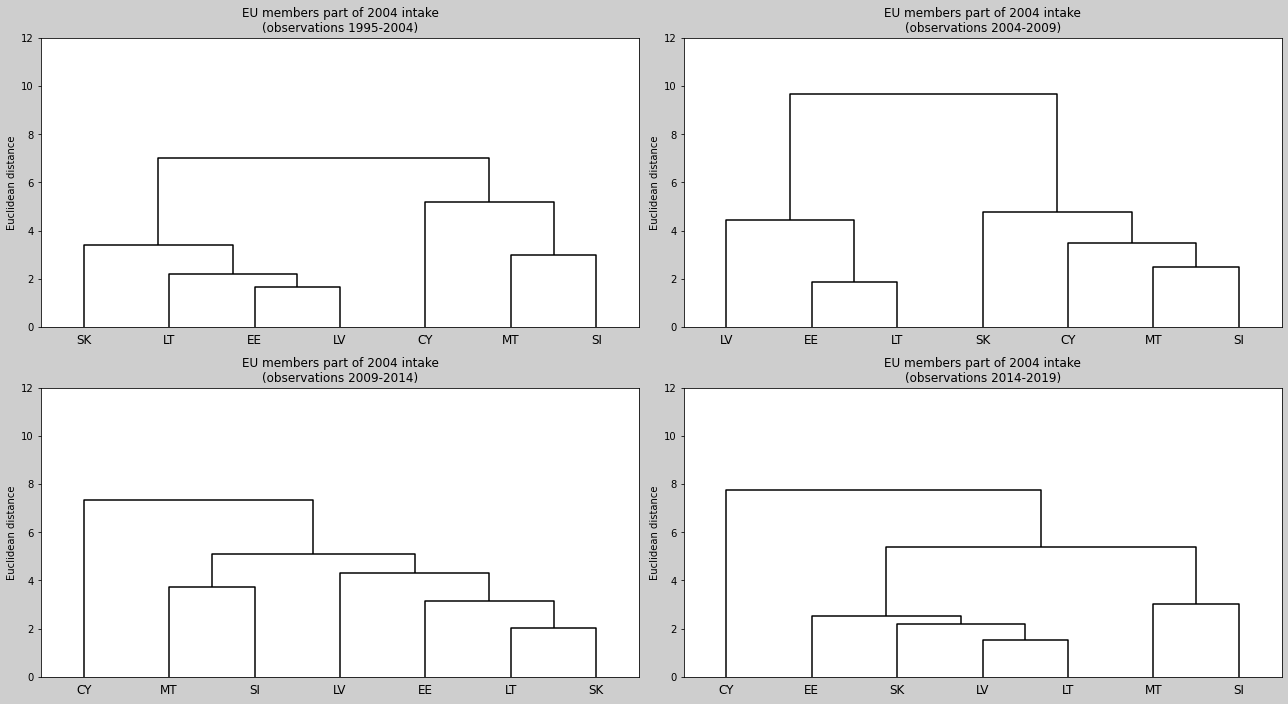

In [23]:
dendogram_plot(df_04_ea_2004, df_04_ea_2009, df_04_ea_2014, df_04_ea_2019,
               y0=1995, title='EU members part of 2004 intake', ymax=12)

### EU members part of intake 2004

In [24]:
df_04_nonea_2004 = transformer(range(1995,2005,1), c_lib['2004 nonEA'], std=True)
df_04_nonea_2009 = transformer(range(2005,2010,1), c_lib['2004 nonEA'], std=True)
df_04_nonea_2014 = transformer(range(2010,2015,1), c_lib['2004 nonEA'], std=True)
df_04_nonea_2019 = transformer(range(2015,2020,1), c_lib['2004 nonEA'], std=True)

### <font color='goldenrod'> Figure: 3 </font>

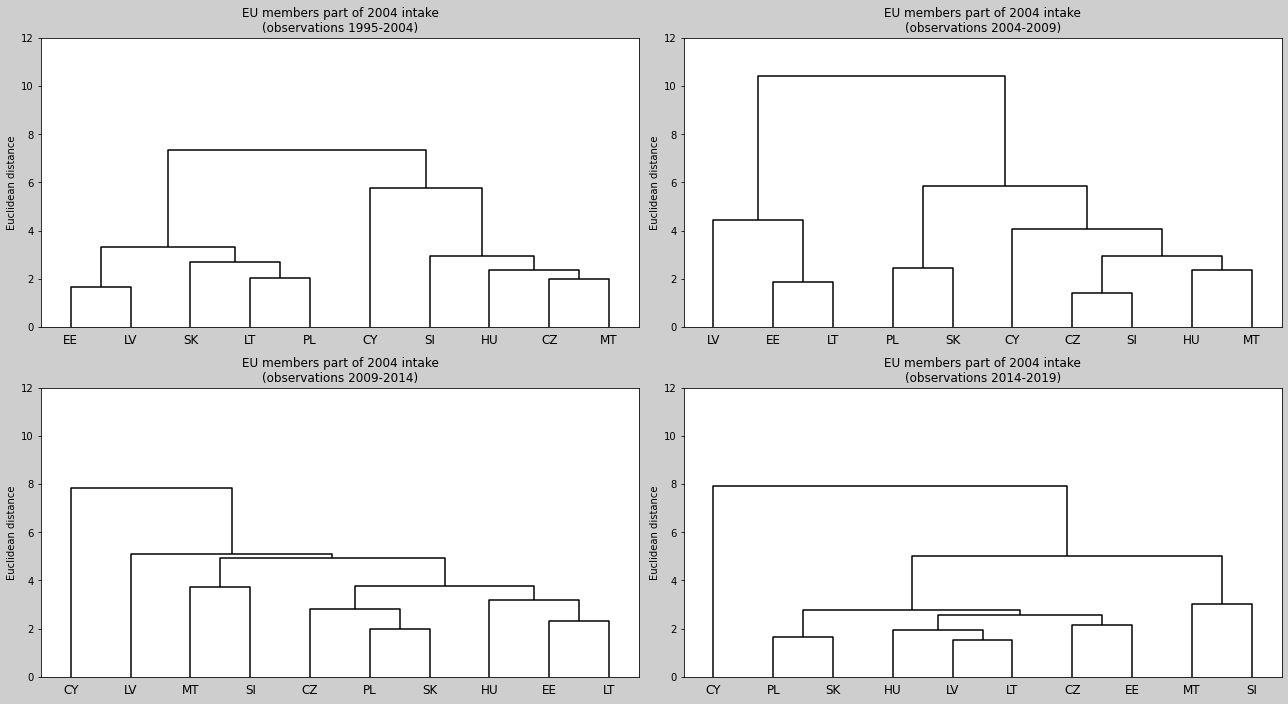

In [25]:
dendogram_plot(df_04_nonea_2004, df_04_nonea_2009, df_04_nonea_2014, df_04_nonea_2019,
               y0=1995, title='EU members part of 2004 intake', ymax=12)

In [26]:
df_04_nonea_2004 = unscaled_transformer(range(1995,2005,1), c_lib['2004 nonEA'], std=True)
df_04_nonea_2009 = unscaled_transformer(range(2005,2010,1), c_lib['2004 nonEA'], std=True)
df_04_nonea_2014 = unscaled_transformer(range(2010,2015,1), c_lib['2004 nonEA'], std=True)
df_04_nonea_2019 = unscaled_transformer(range(2015,2020,1), c_lib['2004 nonEA'], std=True)

In [27]:
df_04_nonea_2004

,CA,Debt,GDPg,Inflation,Private,Unemp,std_CA,std_Debt,std_GDPg,std_Inflation,std_Private,std_Unemp
Cyprus,-0.0278,0.561900,0.046100,0.027500,2.8938,0.037000,0.023045,0.057470,0.024347,0.010927,0.321258,0.006683
Czech Republic,-0.0419,0.188700,0.024444,0.048333,1.3489,0.068200,0.015800,0.067195,0.020125,0.036749,0.078252,0.019188
Estonia,-0.0845,0.059600,0.061300,0.087400,0.5661,0.110500,0.032126,0.011853,0.037857,0.088772,0.168681,0.017083
Hungary,-0.0635,0.614300,0.034900,0.130100,0.5374,0.073500,0.019699,0.095188,0.014098,0.079873,0.101615,0.017148
Latvia,-0.0654,0.142143,0.054400,0.073300,0.3871,0.134700,0.031609,0.023398,0.034452,0.078162,0.176613,0.034274
Lithuania,-0.0800,0.225143,0.060111,0.046222,0.2950,0.142333,0.023725,0.029425,0.032842,0.075360,0.060802,0.024337
Malta,-0.0294,0.628300,0.027500,0.028600,1.2348,0.066200,0.021773,0.085448,0.026467,0.007677,0.080314,0.009319
Poland,-0.0366,0.419000,0.044900,0.103600,0.3341,0.153300,0.022785,0.040724,0.020146,0.085921,0.091958,0.036381
Slovak Republic,-0.0593,0.398000,0.043000,0.077600,0.4878,0.160700,0.037801,0.096484,0.024088,0.025587,0.068610,0.030166
Slovenia,-0.0096,0.241400,0.039100,0.079700,0.4927,0.067900,0.014284,0.029893,0.007752,0.026978,0.126125,0.004280


In [28]:
df_04_nonea_2009

,CA,Debt,GDPg,Inflation,Private,Unemp,std_CA,std_Debt,std_GDPg,std_Inflation,std_Private,std_Unemp
Cyprus,-0.0874,0.5460,0.0326,0.0222,2.6936,0.0456,0.039151,0.074743,0.029972,0.014906,0.240603,0.007537
Czech Republic,-0.0268,0.2882,0.0340,0.0294,1.2996,0.0628,0.010964,0.025762,0.048151,0.020623,0.065843,0.014114
Estonia,-0.0892,0.0496,0.0146,0.0520,1.2196,0.0750,0.071079,0.013012,0.107797,0.038164,0.182109,0.035784
Hungary,-0.0604,0.6764,0.0056,0.0516,0.9600,0.0762,0.029314,0.067281,0.044219,0.018636,0.153943,0.011904
Latvia,-0.1158,0.1658,0.0302,0.0844,1.0636,0.0970,0.116240,0.113361,0.114920,0.045275,0.170130,0.046589
Lithuania,-0.0918,0.1868,0.0280,0.0554,0.6942,0.0758,0.066691,0.053457,0.102939,0.033538,0.132426,0.037739
Malta,-0.0574,0.6484,0.0268,0.0246,1.5186,0.0662,0.033560,0.033879,0.022687,0.014639,0.131024,0.003834
Poland,-0.0502,0.4698,0.0474,0.0264,0.5568,0.1128,0.017627,0.018992,0.018036,0.012260,0.113964,0.043974
Slovak Republic,-0.0578,0.3228,0.0520,0.0278,0.5604,0.1254,0.016438,0.032042,0.063020,0.014237,0.090052,0.025628
Slovenia,-0.0282,0.2632,0.0250,0.0304,0.9508,0.0552,0.017908,0.049947,0.057702,0.018105,0.154416,0.008815


In [29]:
df_04_nonea_2014

,CA,Debt,GDPg,Inflation,Private,Unemp,std_CA,std_Debt,std_GDPg,std_Inflation,std_Private,std_Unemp
Cyprus,-0.0450,0.8238,-0.0188,0.0186,3.2978,0.1160,0.036332,0.232836,0.033484,0.017009,0.170825,0.044878
Czech Republic,-0.0150,0.4142,0.0114,0.0168,1.5012,0.0680,0.014714,0.031300,0.014519,0.010826,0.040270,0.004472
Estonia,0.0044,0.0866,0.0350,0.0314,1.2068,0.1100,0.014276,0.021349,0.022967,0.017416,0.090806,0.036708
Hungary,0.0140,0.7862,0.0154,0.0320,1.0370,0.0990,0.012981,0.016498,0.020107,0.024207,0.105745,0.014018
Latvia,-0.0194,0.4230,0.0196,0.0120,1.0166,0.1468,0.021824,0.028311,0.041046,0.021012,0.186712,0.034795
Lithuania,-0.0064,0.3844,0.0372,0.0198,0.6216,0.1382,0.028606,0.017827,0.015287,0.016100,0.079914,0.028429
Malta,0.0162,0.6558,0.0464,0.0190,1.5516,0.0624,0.047188,0.027344,0.026302,0.010100,0.113293,0.004037
Poland,-0.0390,0.5396,0.0286,0.0230,0.7440,0.0972,0.016793,0.019347,0.016041,0.018235,0.033279,0.005070
Slovak Republic,-0.0114,0.4890,0.0278,0.0198,0.7184,0.1394,0.033627,0.062610,0.019280,0.018472,0.052027,0.005128
Slovenia,0.0162,0.5774,0.0028,0.0164,1.0908,0.0886,0.025859,0.171803,0.021040,0.008764,0.068976,0.011589


In [30]:
df_04_nonea_2019

,CA,Debt,GDPg,Inflation,Private,Unemp,std_CA,std_Debt,std_GDPg,std_Inflation,std_Private,std_Unemp
Cyprus,-0.0402,0.9940,0.0462,-0.0012,3.0548,0.1090,0.022354,0.058852,0.014290,0.011300,0.344583,0.032070
Czech Republic,0.0076,0.3456,0.0372,0.0168,1.4698,0.0320,0.008678,0.037340,0.014822,0.011145,0.034608,0.012510
Estonia,0.0164,0.0912,0.0398,0.0206,1.0572,0.0572,0.005771,0.008289,0.014906,0.015789,0.063464,0.009011
Hungary,0.0178,0.7146,0.0404,0.0178,0.7326,0.0450,0.018593,0.043224,0.012300,0.015401,0.070348,0.013379
Latvia,0.0028,0.3796,0.0314,0.0170,0.7390,0.0838,0.010803,0.018338,0.009154,0.014195,0.051342,0.015156
Lithuania,0.0012,0.3830,0.0340,0.0168,0.5586,0.0730,0.022219,0.035299,0.010770,0.017065,0.006693,0.012329
Malta,0.0342,0.4910,0.0650,0.0132,1.2658,0.0428,0.024864,0.059695,0.022705,0.003033,0.052770,0.007596
Poland,-0.0058,0.5012,0.0440,0.0088,0.7774,0.0514,0.006834,0.031444,0.008515,0.015123,0.029467,0.017271
Slovak Republic,-0.0232,0.5088,0.0320,0.0118,0.8902,0.0832,0.003633,0.016316,0.011158,0.015353,0.051935,0.023307
Slovenia,0.0524,0.7422,0.0356,0.0082,0.7718,0.0662,0.009529,0.066751,0.010431,0.010378,0.072953,0.019241


### Euro Area members after intake 2004

#### Euro Area members after intake 2004 - moving window

In [31]:
df_04_ea_all_2004 = transformer(range(1995,2005,1), c_lib['Org. plus 2004 EA'], std=True)
df_04_ea_all_2009 = transformer(range(2005,2010,1), c_lib['Org. plus 2004 EA'], std=True)
df_04_ea_all_2014 = transformer(range(2010,2015,1), c_lib['Org. plus 2004 EA'], std=True)
df_04_ea_all_2019 = transformer(range(2015,2020,1), c_lib['Org. plus 2004 EA'], std=True)

### <font color='goldenrod'> Figure: 4 </font>

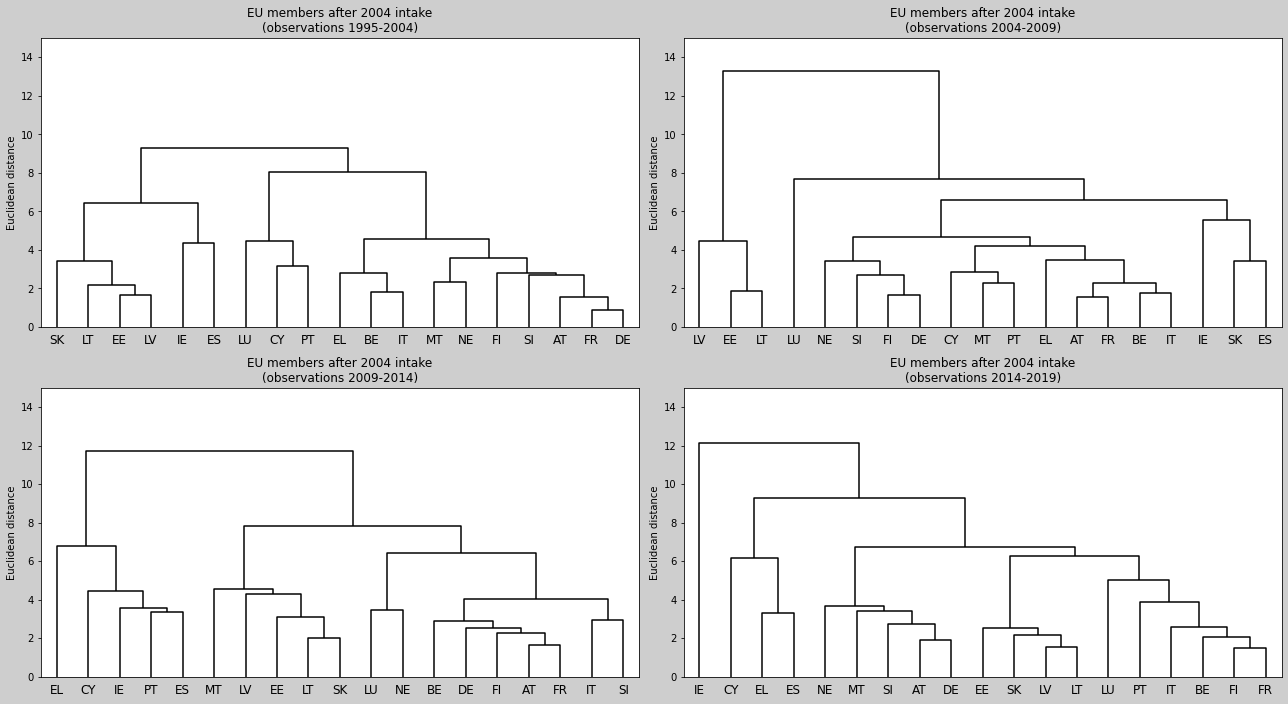

In [32]:
dendogram_plot(df_04_ea_all_2004, df_04_ea_all_2009, df_04_ea_all_2014, df_04_ea_all_2019,
               y0=1995, title='EU members after 2004 intake', ymax=15)

#### Euro Area members after intake 2004 - fixed time perspective

In [33]:
df_04_ea_all_2004 = transformer(range(1995,2005,1), c_lib['Org. plus 2004 EA'], std=True)
df_04_ea_all_2009 = transformer(range(1995,2010,1), c_lib['Org. plus 2004 EA'], std=True)
df_04_ea_all_2014 = transformer(range(1995,2015,1), c_lib['Org. plus 2004 EA'], std=True)
df_04_ea_all_2019 = transformer(range(1995,2020,1), c_lib['Org. plus 2004 EA'], std=True)

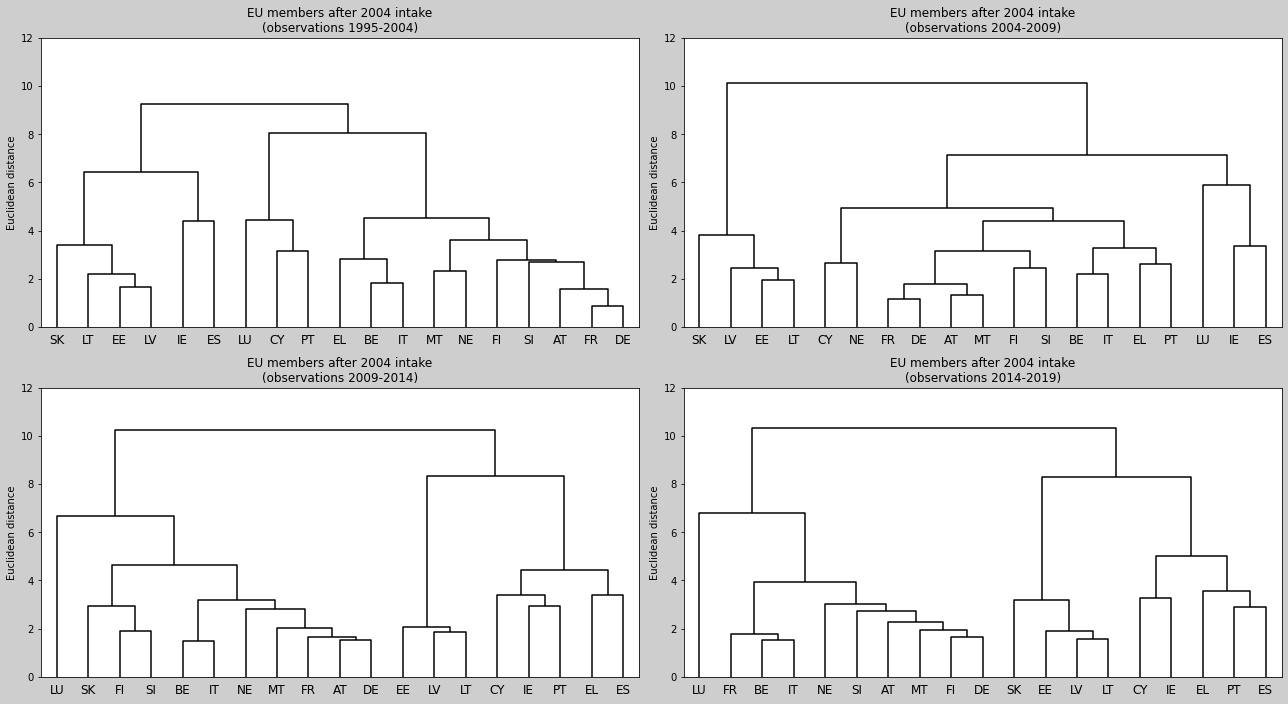

In [34]:
dendogram_plot(df_04_ea_all_2004, df_04_ea_all_2009, df_04_ea_all_2014, df_04_ea_all_2019,
               y0=1995, title='EU members after 2004 intake', ymax=12)

### European Union All

#### EU members after intake 2004 - moving window

In [35]:
df_04_all_2004 = transformer(range(1995,2005,1), c_lib['Org. plus 2004 nonEA'], std=True)
df_04_all_2009 = transformer(range(2005,2010,1), c_lib['Org. plus 2004 nonEA'], std=True)
df_04_all_2014 = transformer(range(2010,2015,1), c_lib['Org. plus 2004 nonEA'], std=True)
df_04_all_2019 = transformer(range(2015,2020,1), c_lib['Org. plus 2004 nonEA'], std=True)

### <font color='goldenrod'> Figure: To be added next time </font>

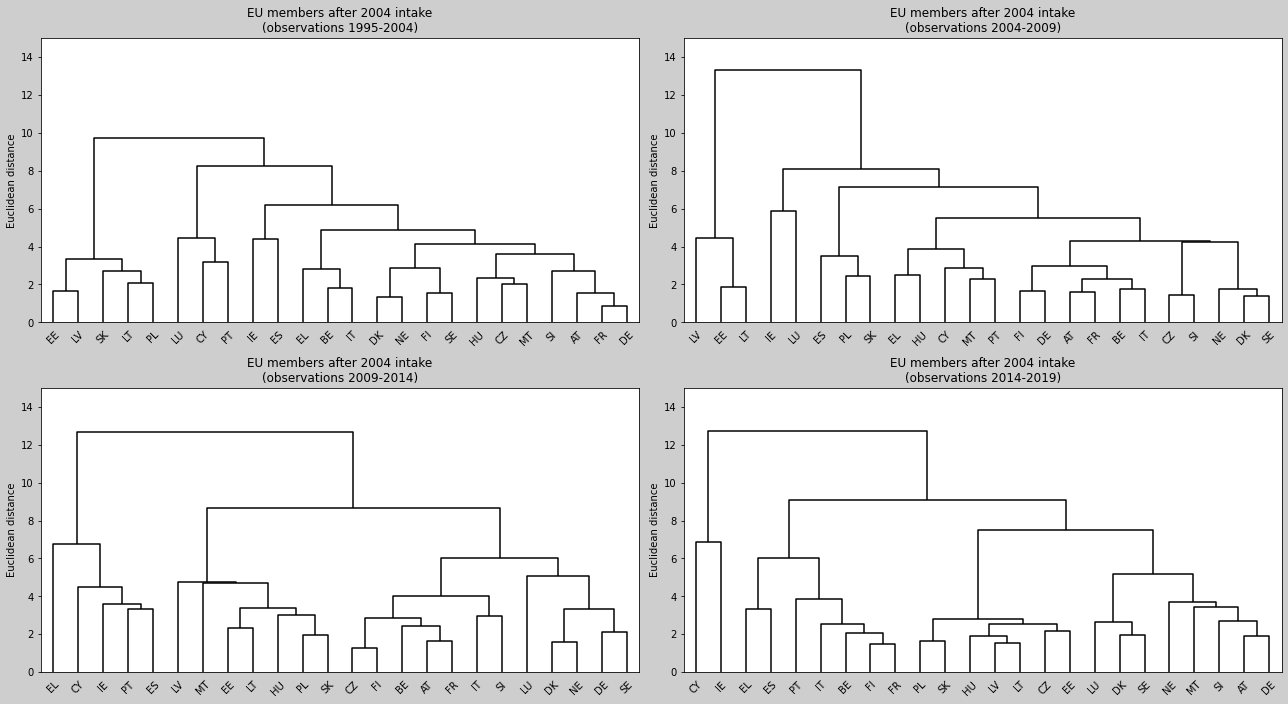

In [36]:
dendogram_plot(df_04_all_2004, df_04_all_2009, df_04_all_2014, df_04_all_2019,
               y0=1995, title='EU members after 2004 intake', ymax=15)

In [38]:
df_04_all_2004 = unscaled_transformer(range(1995,2005,1), c_lib['Org. plus 2004 nonEA'], std=True)
df_04_all_2009 = unscaled_transformer(range(2005,2010,1), c_lib['Org. plus 2004 nonEA'], std=True)
df_04_all_2014 = unscaled_transformer(range(2010,2015,1), c_lib['Org. plus 2004 nonEA'], std=True)
df_04_all_2019 = unscaled_transformer(range(2015,2020,1), c_lib['Org. plus 2004 nonEA'], std=True)

In [39]:
df_04_all_2004

,CA,Debt,GDPg,Inflation,Private,Unemp,std_CA,std_Debt,std_GDPg,std_Inflation,std_Private,std_Unemp
Austria,-0.0082,0.657500,0.024400,0.015200,1.1538,0.045100,0.020242,0.023661,0.009477,0.005673,0.084949,0.004864
Belgium,0.0470,1.141300,0.024100,0.016600,1.0910,0.083800,0.013984,0.116414,0.011455,0.005582,0.090729,0.011013
Cyprus,-0.0278,0.561900,0.046100,0.027500,2.8938,0.037000,0.023045,0.057470,0.024347,0.010927,0.321258,0.006683
Czech Republic,-0.0419,0.188700,0.024444,0.048333,1.3489,0.068200,0.015800,0.067195,0.020125,0.036749,0.078252,0.019188
Denmark,0.0228,0.561500,0.022400,0.019700,1.5596,0.052600,0.013620,0.095937,0.012204,0.005376,0.136926,0.007905
Estonia,-0.0845,0.059600,0.061300,0.087400,0.5661,0.110500,0.032126,0.011853,0.037857,0.088772,0.168681,0.017083
Finland,0.0542,0.462200,0.040200,0.014400,0.9364,0.110900,0.015957,0.058685,0.015747,0.009095,0.080272,0.024145
France,0.0186,0.607200,0.023400,0.016500,0.9819,0.096600,0.014796,0.028393,0.010710,0.005949,0.055750,0.010885
Germany,0.0011,0.596200,0.012900,0.013200,1.1801,0.089200,0.019359,0.028299,0.010734,0.004517,0.061798,0.008284
Greece,-0.0470,1.025900,0.039300,0.045500,0.5153,0.106900,0.016872,0.031821,0.010709,0.022057,0.143436,0.007015


In [40]:
df_04_all_2009

,CA,Debt,GDPg,Inflation,Private,Unemp,std_CA,std_Debt,std_GDPg,std_Inflation,std_Private,std_Unemp
Austria,0.0330,0.6960,0.0142,0.0192,1.2644,0.0502,0.008916,0.057858,0.030573,0.010134,0.036875,0.005718
Belgium,0.0122,0.9346,0.0140,0.0222,1.4406,0.0784,0.012558,0.047427,0.022417,0.016115,0.247541,0.006066
Cyprus,-0.0874,0.5460,0.0326,0.0222,2.6936,0.0456,0.039151,0.074743,0.029972,0.014906,0.240603,0.007537
Czech Republic,-0.0268,0.2882,0.0340,0.0294,1.2996,0.0628,0.010964,0.025762,0.048151,0.020623,0.065843,0.014114
Denmark,0.0306,0.3394,0.0034,0.0196,2.1014,0.0452,0.010407,0.050401,0.033538,0.009711,0.176322,0.011389
Estonia,-0.0892,0.0496,0.0146,0.0520,1.2196,0.0750,0.071079,0.013012,0.107797,0.038164,0.182109,0.035784
Finland,0.0306,0.3718,0.0096,0.0184,1.2494,0.0760,0.008735,0.038232,0.053285,0.011971,0.106578,0.008860
France,-0.0020,0.6966,0.0078,0.0174,1.1828,0.0846,0.004359,0.076817,0.022287,0.011059,0.083473,0.006804
Germany,0.0578,0.6730,0.0056,0.0180,1.1336,0.0890,0.007791,0.034271,0.037367,0.009772,0.029407,0.015588
Greece,-0.1160,1.1098,0.0100,0.0306,1.0182,0.0896,0.028775,0.097630,0.037855,0.010784,0.131391,0.008877


In [41]:
df_04_all_2014

,CA,Debt,GDPg,Inflation,Private,Unemp,std_CA,std_Debt,std_GDPg,std_Inflation,std_Private,std_Unemp
Austria,0.0208,0.8222,0.0122,0.0228,1.2836,0.0504,0.006017,0.010354,0.011389,0.008012,0.027790,0.004037
Belgium,0.0028,1.0422,0.0148,0.0200,1.7308,0.0802,0.013627,0.025292,0.009550,0.011511,0.124401,0.006458
Cyprus,-0.0450,0.8238,-0.0188,0.0186,3.2978,0.1160,0.036332,0.232836,0.033484,0.017009,0.170825,0.044878
Czech Republic,-0.0150,0.4142,0.0114,0.0168,1.5012,0.0680,0.014714,0.031300,0.014519,0.010826,0.040270,0.004472
Denmark,0.0724,0.4438,0.0118,0.0164,2.1914,0.0752,0.010922,0.012795,0.006611,0.011014,0.040272,0.003834
Estonia,0.0044,0.0866,0.0350,0.0314,1.2068,0.1100,0.014276,0.021349,0.022967,0.017416,0.090806,0.036708
Finland,-0.0102,0.5296,0.0060,0.0232,1.4686,0.0826,0.014446,0.053882,0.020988,0.009203,0.015837,0.004159
France,-0.0080,0.9040,0.0120,0.0156,1.3690,0.0978,0.002345,0.039389,0.008216,0.007436,0.035334,0.005263
Germany,0.0656,0.7948,0.0222,0.0164,1.0228,0.0568,0.006269,0.025636,0.018281,0.007162,0.028718,0.007950
Greece,-0.0552,1.7078,-0.0494,0.0130,1.3226,0.2180,0.041361,0.156018,0.041362,0.025990,0.019920,0.063119


In [42]:
df_04_all_2019

,CA,Debt,GDPg,Inflation,Private,Unemp,std_CA,std_Debt,std_GDPg,std_Inflation,std_Private,std_Unemp
Austria,0.0198,0.7800,0.0188,0.0152,1.2232,0.0532,0.007190,0.057840,0.006723,0.006301,0.014990,0.006099
Belgium,0.0044,1.0202,0.0168,0.0162,1.8472,0.0696,0.008019,0.031340,0.002588,0.007155,0.074157,0.012700
Cyprus,-0.0402,0.9940,0.0462,-0.0012,3.0548,0.1090,0.022354,0.058852,0.014290,0.011300,0.344583,0.032070
Czech Republic,0.0076,0.3456,0.0372,0.0168,1.4698,0.0320,0.008678,0.037340,0.014822,0.011145,0.034608,0.012510
Denmark,0.0798,0.3586,0.0268,0.0054,2.1958,0.0564,0.006870,0.027328,0.004207,0.004393,0.054302,0.005683
Estonia,0.0164,0.0912,0.0398,0.0206,1.0572,0.0572,0.005771,0.008289,0.014906,0.015789,0.063464,0.009011
Finland,-0.0116,0.6138,0.0182,0.0066,1.4802,0.0830,0.007701,0.019854,0.011345,0.005727,0.027041,0.012042
France,-0.0060,0.9760,0.0158,0.0100,1.4654,0.0946,0.001581,0.011247,0.005215,0.008124,0.043781,0.007603
Germany,0.0788,0.6562,0.0164,0.0122,1.0098,0.0382,0.006611,0.052266,0.007829,0.006458,0.029928,0.005586
Greece,-0.0246,1.8392,0.0078,0.0026,1.2078,0.2132,0.007603,0.039846,0.011432,0.008620,0.074711,0.030939


# No STD

### EU members prior 2004 intake

#### df

In [168]:
df_O_all_1998 = transformer(range(1980,1999,1), c_lib['Org. EA'])
df_O_all_2004 = transformer(range(1999,2005,1), c_lib['Org. EA'])
df_O_all_2009a = transformer(range(2005,2010,1), c_lib['Org. EA'])
df_O_all_2009b = transformer(range(1999,2010,1), c_lib['Org. EA'])
df_O_all_2014 = transformer(range(2005,2015,1), c_lib['Org. EA'])
df_O_all_2019a = transformer(range(2010,2020,1), c_lib['Org. EA'])
df_O_all_2019b = transformer(range(2015,2020,1), c_lib['Org. EA'])

#### Members priod 2004 - time windows (2004)

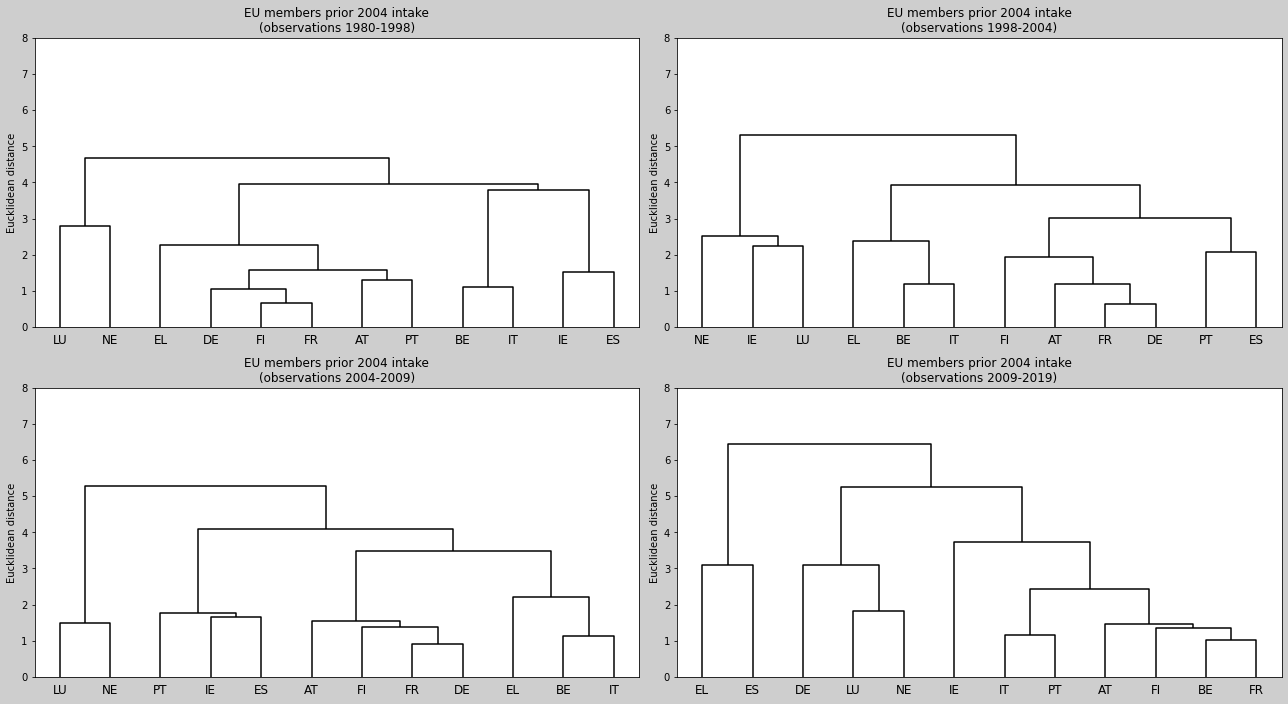

In [169]:
dendogram_plot(df_O_all_1998, df_O_all_2004, df_O_all_2009a, df_O_all_2019a, title='EU members prior 2004 intake', ymax=8)

#### Members priod 2004 - time windows (2015)

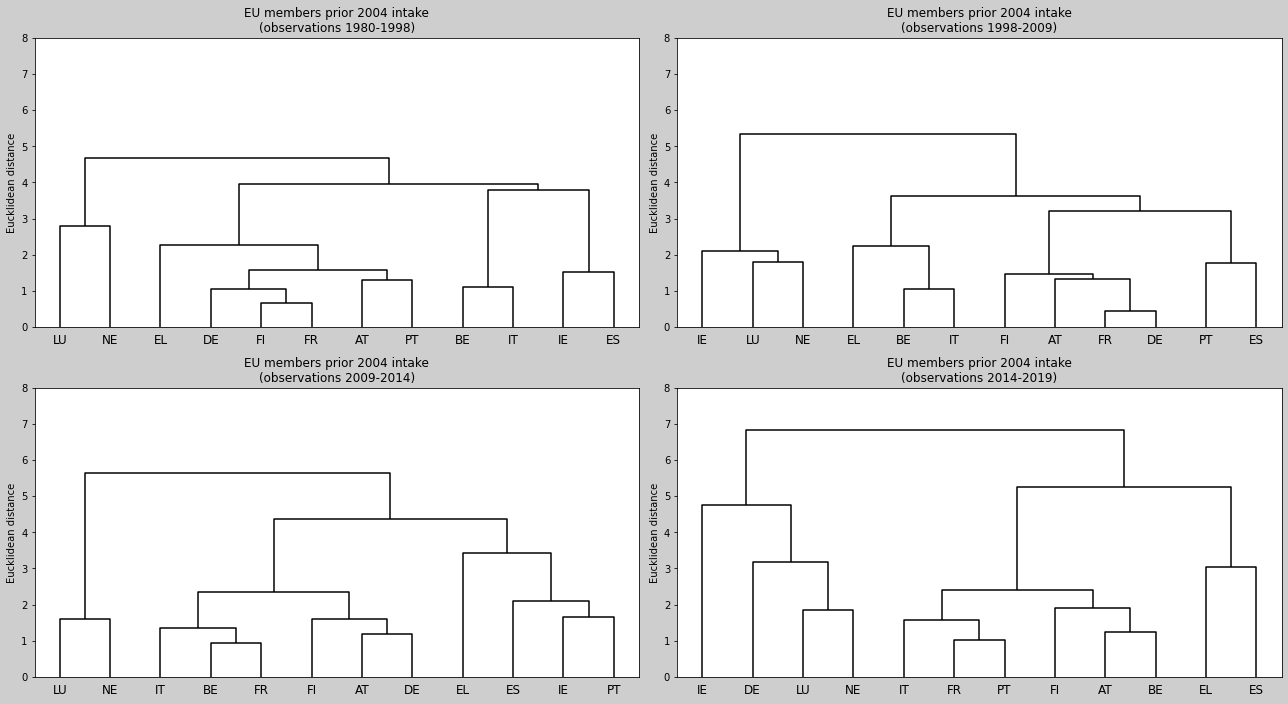

In [184]:
dendogram_plot(df_O_all_1998, df_O_all_2009b, df_O_all_2014, df_O_all_2019b, title='EU members prior 2004 intake', ymax=8)

### Euro Area members part of intake 2004

In [171]:
df_04_ea_2004 = transformer(range(1995,2005,1), c_lib['2004 EA'])
df_04_ea_2009 = transformer(range(2005,2010,1), c_lib['2004 EA'])
df_04_ea_2014 = transformer(range(2010,2015,1), c_lib['2004 EA'])
df_04_ea_2019 = transformer(range(2015,2020,1), c_lib['2004 EA'])

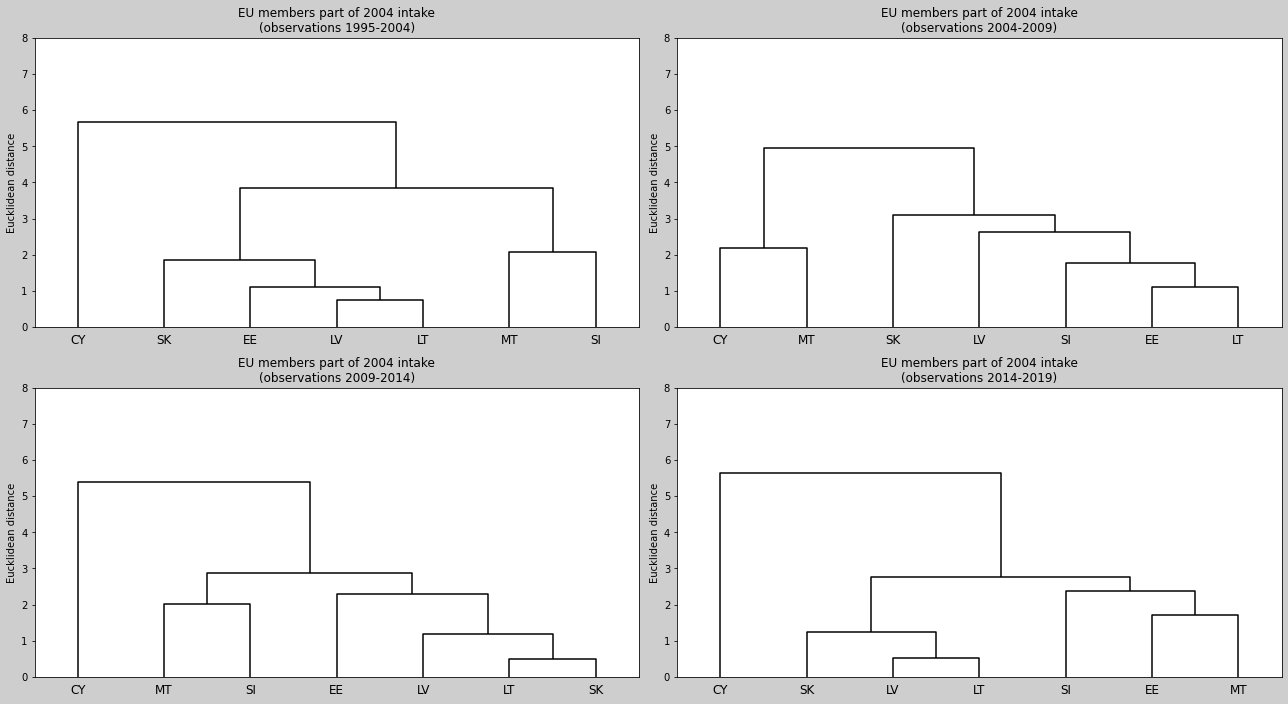

In [182]:
dendogram_plot(df_04_ea_2004, df_04_ea_2009, df_04_ea_2014, df_04_ea_2019,
               y0=1995, title='EU members part of 2004 intake', ymax=8)

### EU members part of intake 2004

In [173]:
df_04_nonea_2004 = transformer(range(1995,2005,1), c_lib['2004 nonEA'])
df_04_nonea_2009 = transformer(range(2005,2010,1), c_lib['2004 nonEA'])
df_04_nonea_2014 = transformer(range(2010,2015,1), c_lib['2004 nonEA'])
df_04_nonea_2019 = transformer(range(2015,2020,1), c_lib['2004 nonEA'])

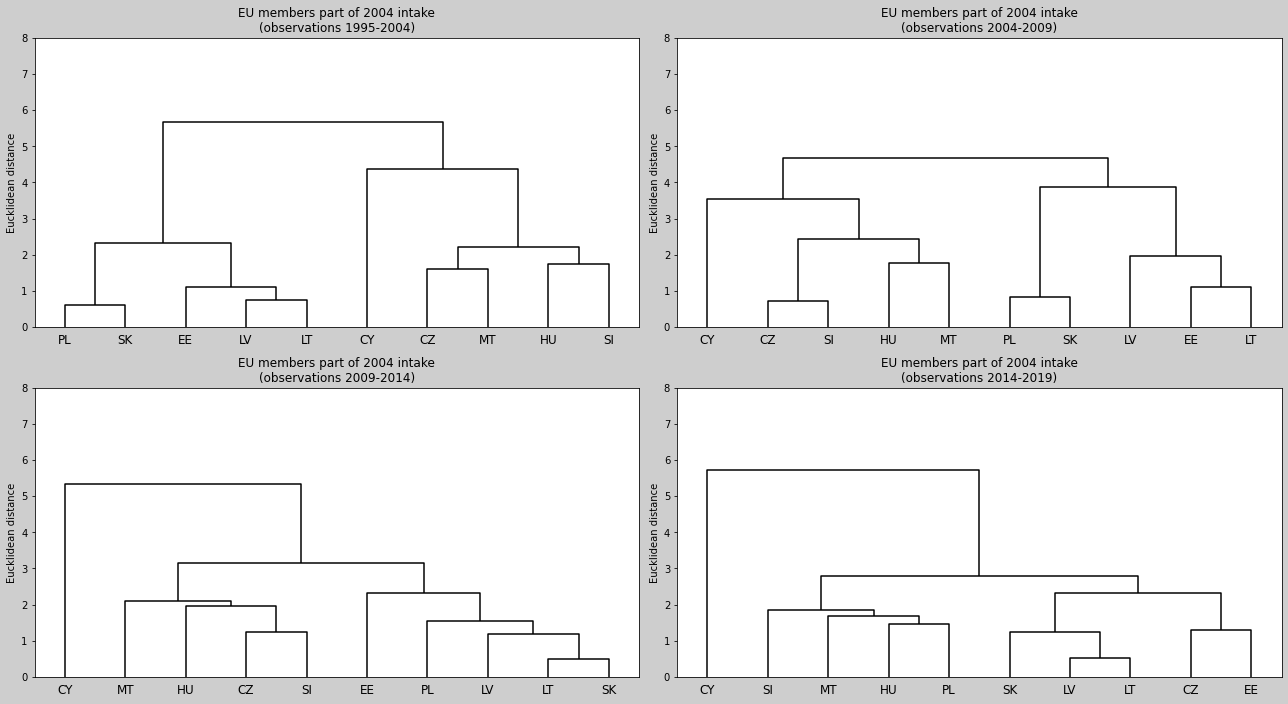

In [181]:
dendogram_plot(df_04_nonea_2004, df_04_nonea_2009, df_04_nonea_2014, df_04_nonea_2019,
               y0=1995, title='EU members part of 2004 intake', ymax=8)

### Euro Area members after intake 2004

#### Euro Area members after intake 2004 - moving window

In [175]:
df_04_all_2004 = transformer(range(1995,2005,1), c_lib['Org. plus 2004 EA'])
df_04_all_2009 = transformer(range(2005,2010,1), c_lib['Org. plus 2004 EA'])
df_04_all_2014 = transformer(range(2010,2015,1), c_lib['Org. plus 2004 EA'])
df_04_all_2019 = transformer(range(2015,2020,1), c_lib['Org. plus 2004 EA'])

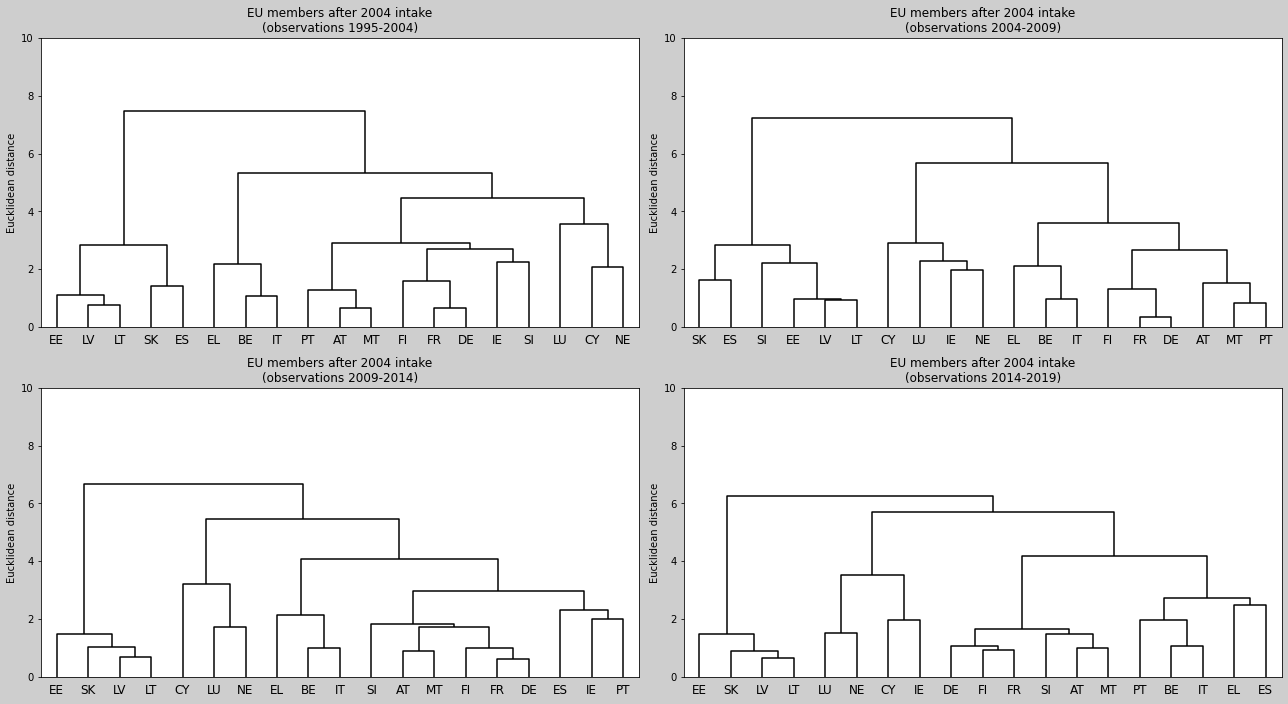

In [180]:
dendogram_plot(df_04_all_2004, df_04_all_2009, df_04_all_2014, df_04_all_2019,
               y0=1995, title='EU members after 2004 intake', ymax=10)

#### Euro Area members after intake 2004 - fixed time perspective

In [177]:
df_04_all_2004 = transformer(range(1995,2005,1), c_lib['Org. plus 2004 EA'])
df_04_all_2009 = transformer(range(1995,2010,1), c_lib['Org. plus 2004 EA'])
df_04_all_2014 = transformer(range(1995,2015,1), c_lib['Org. plus 2004 EA'])
df_04_all_2019 = transformer(range(1995,2020,1), c_lib['Org. plus 2004 EA'])

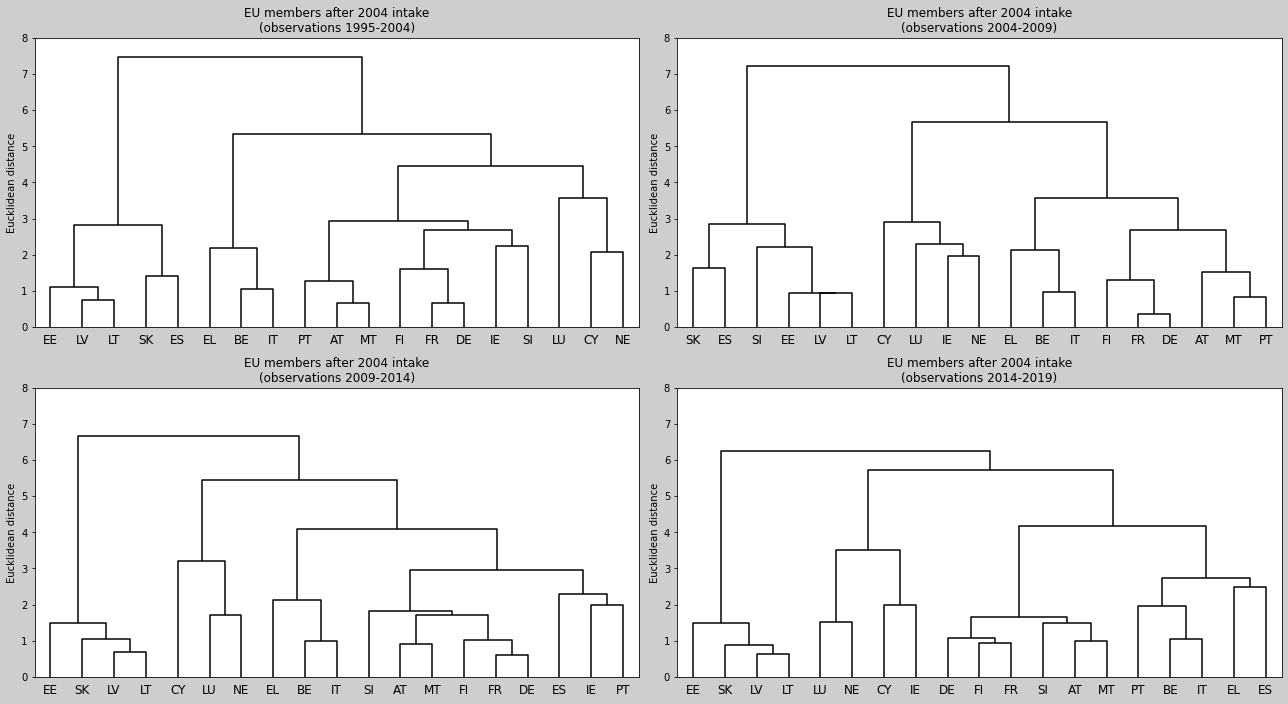

In [179]:
dendogram_plot(df_04_all_2004, df_04_all_2009, df_04_all_2014, df_04_all_2019,
               y0=1995, title='EU members after 2004 intake', ymax=8)

# Coloured clusters

In [12]:
def dendogram_plot(df1, df2, df3, df4, y0=1980, title='EU members', ymax=15, save=False):
    plt.figure(4, figsize=(18,10), facecolor='#cecece')
    
    labelList = df1.index.map(mapper)

    plt.subplot(2, 2, 1)
    linked = linkage(df1, 'ward')
    dendrogram(linked, orientation='top', labels=labelList, distance_sort='descending', show_leaf_counts=True)
    plt.title(f'{title}\n(observations {y0}-{df1.name})')
    plt.ylabel('Euclidean distance')
    plt.ylim([0,ymax])

    plt.subplot(2, 2, 2)
    linked = linkage(df2, 'ward')
    dendrogram(linked, orientation='top', labels=labelList, distance_sort='descending', show_leaf_counts=True)
    plt.title(f'{title}\n(observations {df1.name}-{df2.name})')
    plt.ylabel('Euclidean distance')
    plt.ylim([0,ymax])

    plt.subplot(2, 2, 3)
    linked = linkage(df3, 'ward')
    dendrogram(linked, orientation='top', labels=labelList, distance_sort='descending', show_leaf_counts=True)
    plt.title(f'{title}\n(observations {df2.name}-{df3.name})')
    plt.ylabel('Euclidean distance')
    plt.ylim([0,ymax])

    plt.subplot(2, 2, 4)
    linked = linkage(df4, 'ward')
    dendrogram(linked, orientation='top', labels=labelList, distance_sort='descending', show_leaf_counts=True)
    plt.title(f'{title}\n(observations {df3.name}-{df4.name})')
    plt.ylabel('Euclidean distance')
    plt.ylim([0,ymax])

    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    # plt.suptitle('Original EU members over time 1980-2019 HAC analysis')
    
    if save:
        save_fig_name = title.replace(' ','_')
        plt.savefig(f'{save_fig_name}.png', facecolor='#cecece')
    
    plt.show()

In [13]:
df_O_all_1998 = transformer(range(1980,1999,1), c_lib['Org. EA'], std=True)
df_O_all_2004 = transformer(range(1999,2005,1), c_lib['Org. EA'], std=True)
df_O_all_2009a = transformer(range(2005,2010,1), c_lib['Org. EA'], std=True)
df_O_all_2009b = transformer(range(1999,2010,1), c_lib['Org. EA'], std=True)
df_O_all_2014 = transformer(range(2005,2015,1), c_lib['Org. EA'], std=True)
df_O_all_2019a = transformer(range(2010,2020,1), c_lib['Org. EA'], std=True)
df_O_all_2019b = transformer(range(2015,2020,1), c_lib['Org. EA'], std=True)

#### Members priod 2004 - time windows (2004)

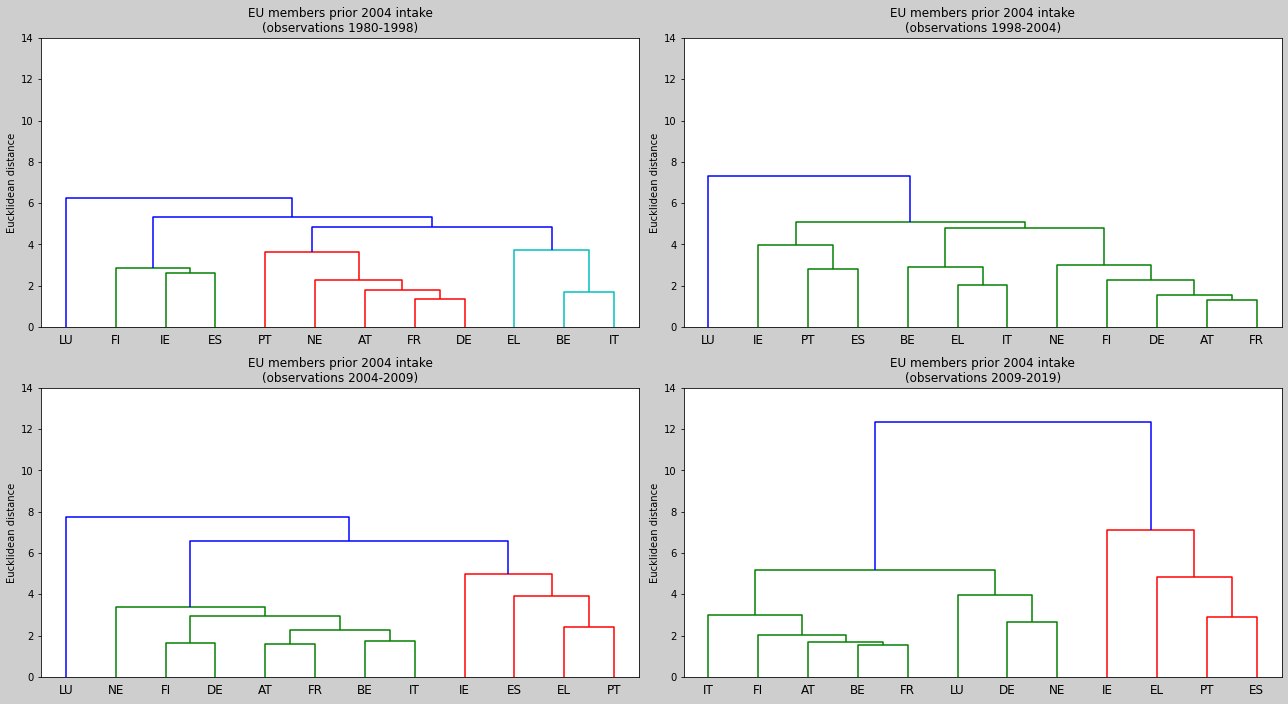

In [14]:
dendogram_plot(df_O_all_1998, df_O_all_2004, df_O_all_2009a, df_O_all_2019a, title='EU members prior 2004 intake', ymax=14)